In [347]:
import pandas as pd
import matplotlib.pyplot as plt
import credentials
import numpy as np
import sqlconnector as sql
import pickle5 as pickle
from scipy.stats import zscore
from sklearn.decomposition import PCA
from scipy import stats
from random import sample
import math
import credentials
import sqlconnector as sql
import credentials

In [364]:
# Sort features in terms of total cumulative pnl and pick top 20
def top_features(dic, top):
    cumul_pnl = {}
    for key, val in dic.items():
        cumul_pnl[key] = sum(val)
    
    sort_dic = dict(sorted(cumul_pnl.items(), key=lambda item: item[1]))
    return list(sort_dic.keys())[-top:]

In [356]:
def quantile(data, features, num_funds=50, month=1):
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for
    output: a dict where keys are features and values are list of pnls over time
    '''
    
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = {}
    for feature in features:
        pnl[feature] = []
        for date in dates[::month]:
            df = data[(data.statistic_date == date) & (data[feature].isna() == False)].sort_values(by=feature, ascending=False)
            ret = 0
            funds = df.fund_id[:num_funds]
            if month == 1:
                ret += sum(df.ret[:num_funds])/num_funds
            else:
                
                # Iterate through funds and calculate t - month look ahead return
                for fund in funds:
                    ret_per_fund = 1
                    for i in range(month):
                        if i == 0:
                            ret_per_fund *= (1+df[df.fund_id == fund].ret.values[0]/num_funds)
                        else:
                            month_ret = data[(data.statistic_date == (date + pd.DateOffset(months=i))) & (data.fund_id == fund)].ret.values
                            if month_ret.size > 0:
                                ret_per_fund *= (1 + month_ret[0]/num_funds)
                            else:
                                break
                    ret += ret_per_fund-1
            pnl[feature].append(ret)
    return pnl

In [30]:
def performance_matrix(df,metrics,annualized_factor = 12):

    performance_matrix = []
    for metric in metrics:
        if metric == 'mean':
            performance_matrix.append(df.mean() * annualized_factor)
        elif metric == 'volatility':
            performance_matrix.append(df.std() * np.sqrt(annualized_factor))
        elif metric == 'sharpe':
            performance_matrix.append(df.mean() * annualized_factor / (df.std() * np.sqrt(annualized_factor)))
        elif metric == 'skew':
            performance_matrix.append(df.skew())
        elif metric == 'excess_kurtosis':
            performance_matrix.append(df.kurtosis() - 3)
        elif metric == 'var':
            performance_matrix.append(df.quantile(0.05))
        elif metric =='cvar':
            performance_matrix.append(df[df < df.quantile(0.05)].mean())
        elif metric =='max_drawdown':
            cum_returns = (1 + df).cumprod()
            rolling_max = cum_returns.cummax()
            drawdown = (cum_returns - rolling_max) / rolling_max
            performance_matrix.append(drawdown.min())
        else:
            raise NoSuchMetricError( 'Metric ' + metric + ' is not valid!')
            
    performance_matrix = pd.concat(performance_matrix,axis=1)
    performance_matrix.columns = metrics

    return performance_matrix.T

In [60]:
def quantile_delayed(data, return_data, features, num_funds=50, month=1, delay=5):
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months with delay
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for, delay (integer) - number of days it takes for us to buy funds
    output: a dict where keys are features and values are list of pnls over time
    '''
    
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = {}
    for feature in features:
        pnl[feature] = []
        for date in dates[::month]:
            df = data[(data.statistic_date == date) & (data[feature].isna() == False)].sort_values(by=feature, ascending=False)
            ret = 0
            funds = df.fund_id[:num_funds]
            
            # Iterate through funds and calculate t - month look ahead return
            for fund in funds:
                ret_per_fund = 1
                for i in range(month):
                    month_ret = return_data[(return_data.statistic_date == (date + pd.DateOffset(months=i)+pd.Timedelta(str(delay)+'d'))) & (return_data.fund_id == fund)].ret.values
                    if month_ret.size > 0:
                        ret_per_fund *= (1 + month_ret[0]/num_funds)
                    else:
                        break
                ret += ret_per_fund-1
            pnl[feature].append(ret)
    return pnl

In [35]:
def quantile_all_features(data, features, num_funds=50, month=1):
    
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months
    but with using scores of multiple specified features
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for
    output: a dict where keys are features and values are list of pnls over time
    '''
            
    col = features+['fund_id', 'ret']
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = []
    for date in dates[::month]:
        df = data[data.statistic_date == date][col].dropna()
        #print(df.columns)
        df['score'] = stats.zscore(df[features]).sum(axis=1)
        ret = 0
        df = df.sort_values(by='score', ascending=False)
        funds = list(df.fund_id[:num_funds])

        if month == 1:
            ret += sum(df.ret[:num_funds])/num_funds
        else:

            # Iterate through funds and calculate t - month look ahead return
            for fund in funds:
                ret_per_fund = 1
                for i in range(month):
                    if i == 0:
                        ret_per_fund *= (1+df[df.fund_id == fund].ret.values[0]/num_funds)
                    else:
                        month_ret = data[(data.statistic_date == (date + pd.DateOffset(months=i))) & (data.fund_id == fund)].ret.values
                        if month_ret.size > 0:
                            ret_per_fund *= (1 + month_ret[0]/num_funds)
                        else:
                            break
                ret += ret_per_fund-1
        pnl.append(ret)
    return pnl

In [36]:
def random_feature_quantile(data, features, num_funds, month, num_comb):
    pnl = {}
    already_selected = []
    
    for i in range(num_comb):
        selected_feature = sample(features, 5)
        if selected_feature not in already_selected:
            already_selected.append(selected_feature)
            pnl[tuple(selected_feature)] = quantile_all_features(data, selected_feature, num_funds, month)
    
    return pnl

In [37]:
def plot_features(pnl, features):
    for fea in features[:]:
        ts = pnl[fea]
        ts = [0 if math.isinf(x) else x for x in ts] 
        plt.plot(dates,np.cumsum(ts)+1)
    
    (df_csi.Price/df_csi.Price[0]).plot(label='CSI')

    plt.legend(features[:]+['csi'],bbox_to_anchor=(1, 1))
    plt.title('Top Performaing Features')
    plt.xlabel('time')
    plt.ylabel('initial capital + cumulative pnl')
    plt.show()

In [61]:
def quantile_all_features_delayed(data, return_data, features, num_funds=50, month=1, delay=5):
    
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months with delay
    but with using scores of multiple specified features
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for
    output: a dict where keys are features and values are list of pnls over time
    '''
            
    col = features+['fund_id', 'ret']
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = []
    for date in dates[::month]:
        df = data[data.statistic_date == date][col].dropna()
        df['score'] = stats.zscore(df[features]).sum(axis=1)
        ret = 0
        df = df.sort_values(by='score', ascending=False)
        funds = list(df.fund_id[:num_funds])
        # Iterate through funds and calculate t - month look ahead return
        for fund in funds:
            ret_per_fund = 1
            for i in range(month):
                month_ret = return_data[(return_data.statistic_date == (date + pd.DateOffset(months=i)+pd.Timedelta(str(delay)+'d'))) & (return_data.fund_id == fund)].ret.values
                if month_ret.size > 0:
                    ret_per_fund *= (1 + month_ret[0]/num_funds)
                else:
                    break
            ret += ret_per_fund-1
        pnl.append(ret)
    return pnl

In [383]:
def random_feature_quantile_delayed(data, return_data, features, num_funds=50, month=1, num_comb=10, num_feature=5, delay=5):
    pnl = {}
    already_selected = []
    
    for i in range(num_comb):
        selected_feature = sample(features, num_feature)
        if selected_feature not in already_selected:
            already_selected.append(selected_feature)
            pnl[tuple(selected_feature)] = quantile_all_features_delayed(data, return_data, selected_feature, num_funds, month, delay)
    
    return pnl

In [406]:
def load_data(filename):
    data = pickle.load(open(filename, "rb"))
    data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric)
    data.statistic_date = pd.to_datetime(data.statistic_date)
    return data

# Data Loading

### load pickle data

In [387]:
# Cleaning on pickle data
data = pickle.load(open('data_new.pickle', "rb"))
data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric)
data.statistic_date = pd.to_datetime(data.statistic_date)
data.head()

statistic_date  fund_id       ret    fee  securities_settlement_receivable  \
0     2017-01-31        8  0.035794  0.005                               NaN   
1     2017-02-28        8 -0.003764  0.005                               NaN   
2     2017-03-31        8 -0.028563  0.005                               NaN   
3     2017-04-30        8 -0.057333  0.005                               NaN   
4     2017-05-31        8  0.054007  0.005                               NaN   

   provision_settlement_fund  stock_income  total_assets  total_liabilities  \
0                        NaN           NaN           NaN                NaN   
1                        NaN           NaN           NaN                NaN   
2                        NaN           NaN           NaN                NaN   
3                        NaN           NaN           NaN                NaN   
4                        NaN           NaN           NaN                NaN   

   refundable_deposits  ...  total_skewness  total_kurtosis  \
0                  NaN  ...       -1.031244        3.479692   
1                  NaN  ...       -1.042016        3.587010   
2                  NaN  ...       -1.047920        3.712064   
3                  NaN  ...       -1.044859        3.762351   
4                  NaN  ...       -1.036409        3.797064   

   total_con_rise_days  total_con_fall_days  quarter_return  \
0                  9.0                  6.0       -0.004176   
1                  9.0                  6.0        0.031469   
2                  9.0                  6.0        0.027587   
3                  9.0                  7.0       -0.028563   
4                  9.0                  7.0       -0.084259   

   total_n_earning_days  total_odds  total_max_drawdown  total_p_earning_days  \
0                 392.0    0.585526            0.530764                 522.0   
1                 397.0    0.588172            0.530764                 534.0   
2                 408.0    0.585519            0.530764                 546.0   
3                 417.0    0.583934            0.530764                 555.0   
4                 430.0    0.579213            0.530764                 562.0   

   total_return  
0      0.706825  
1      0.767920  
2      0.761266  
3      0.710959  
4      0.612864  

[5 rows x 233 columns]

In [388]:
dates = sorted(data.statistic_date.unique())

### load benchmark CSI 300 data

In [389]:
# Data cleaning for CSI 300 - download daily historical data from https://www.investing.com/indices/csi300-historical-data
df_csi = pd.read_csv('CSI300.csv')

df_csi = df_csi.apply(lambda x: x.str.replace(',',''))
df_csi = df_csi.apply(lambda x: x.str.replace('K','000'))
df_csi = df_csi.apply(lambda x: x.str.replace('%',''))

df_csi.Date = pd.to_datetime(df_csi.Date)
df_csi = df_csi.sort_values(by='Date')
df_csi = df_csi[df_csi.Date >= dates[0] - pd.Timedelta('5d')]

df_csi = df_csi.reset_index(drop=True)
df_csi.index = df_csi.Date
df_csi.head()

df_csi = df_csi.iloc[:,1:].apply(pd.to_numeric)

In [390]:
# Fill in dates that have no data
idx = pd.date_range(df_csi.index[0], df_csi.index[-1])
df_csi = df_csi.reindex(idx).fillna(method='ffill')

In [391]:
df_csi.head()

Price     Open     High      Low   Vol.  Change %
2017-01-26  3387.96  3378.26  3395.88  3378.26  65.32      0.36
2017-01-27  3387.96  3378.26  3395.88  3378.26  65.32      0.36
2017-01-28  3387.96  3378.26  3395.88  3378.26  65.32      0.36
2017-01-29  3387.96  3378.26  3395.88  3378.26  65.32      0.36
2017-01-30  3387.96  3378.26  3395.88  3378.26  65.32      0.36

In [392]:
# Calculate one month ahead return
after = df_csi.reindex(df_csi.index + pd.DateOffset(months=1))
after.index = df_csi.index
df_csi['ret'] = (after['Price']/df_csi['Price'] - 1).fillna(method='ffill')

In [395]:
df_csi.to_pickle('benchmark.pickle')

In [352]:
#benchmark = df_csi.loc[dates]['ret'].values

In [396]:
features = data.columns[5:]

### In Sasmple Quantile Trading with no delay

In [397]:
top_20_feature = ['y1_excess_a',
 'm6_ddr3_a',
 'y1_return_a',
 'y1_tr_a',
 'm3_unsys_risk',
 'm3_sor_a',
 'm3_max_return',
 'y1_calmar_a',
 'y1_stock_hm',
 'total_mdd_time',
 'y1_downbeta_cl',
 'm6_downbeta_cl',
 'm6_stdev_a',
 'm6_stdev',
 'm6_max_return',
 'm6_unsys_risk',
 'y1_jensen_a',
 'm3_tracking_error_a',
 'm6_tracking_error_a',
 'y1_s_security']

In [398]:
data_df = data.copy()

In [359]:
# test = data_df[[]]
# test[top_20_feature[-5:]] = data_df[top_20_feature[-5:]]
# test['composite'] = (test.subtract(test.mean(axis=1),axis=0)).div(test.std(axis=1),axis=0).sum(axis=1)
# test['ret'] = data_df.ret
# test['fund_id'] = data_df.fund_id
# test['statistic_date'] = data_df.statistic_date

In [360]:
data_df[features] = data_df[features] - data_df[features].rolling(3).median()

In [361]:
pnl = quantile(data, features, 5, 1)

In [362]:
del pnl['ret_2m']
del pnl['ret_3m']

In [365]:
pnl_df = pd.DataFrame(pnl)

In [366]:
import math

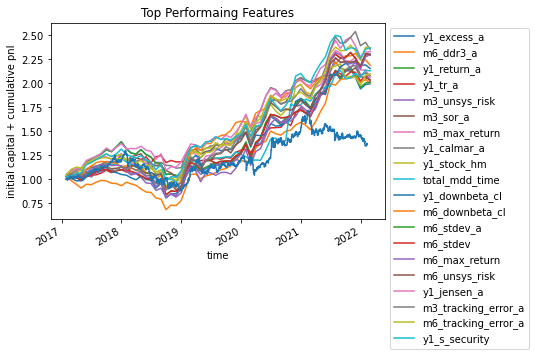

In [367]:
for fea in top_20_feature[:]:
    ts = pnl[fea]
    ts = [0 if math.isinf(x) else x for x in ts] 
    plt.plot(dates,np.cumsum(ts)+1)
    
(df_csi.Price/df_csi.Price[0]).plot(label='CSI')

plt.legend(top_20_feature[:],bbox_to_anchor=(1, 1))
plt.title('Top Performaing Features')
plt.xlabel('time')
plt.ylabel('initial capital + cumulative pnl')
plt.show()


In [28]:
# excess_pnl = {}
# for key, val in pnl.items():
#     excess_pnl[key] = val - benchmark
# excess_pnl_df = pd.DataFrame(excess_pnl)

In [29]:
# excess_pnl_df

In [31]:
performance_df = performance_matrix(pnl_df, ['mean', 'volatility', 'sharpe', 'max_drawdown']).transpose()

In [32]:
performance_df.sort_values(by='sharpe', ascending=False).head(10)

mean  volatility    sharpe  max_drawdown
y1_tr_a              0.197885    0.163427  1.210842     -0.108319
y1_calmar_a          0.208647    0.172459  1.209835     -0.140212
m6_tracking_error_a  0.264453    0.230094  1.149325     -0.226873
y1_kappa_a           0.162224    0.141877  1.143414     -0.150577
y1_sor_a             0.171997    0.151747  1.133442     -0.169077
y1_jensen_a          0.256994    0.229834  1.118174     -0.263229
m3_sor_a             0.200748    0.179657  1.117396     -0.221941
m6_unsys_risk        0.252005    0.226240  1.113885     -0.236060
m6_downbeta_cl       0.229404    0.208304  1.101295     -0.260470
y1_sterling_a        0.169279    0.158061  1.070977     -0.191763

In [33]:
performance_df.sort_values(by='max_drawdown', ascending=False)

mean  volatility    sharpe  max_drawdown
y1_tr_a               0.197885    0.163427  1.210842     -0.108319
y1_ERCVaR             0.056949    0.106252  0.535974     -0.121864
total_calmar_a        0.109674    0.151306  0.724850     -0.122049
y1_min_return         0.053601    0.125008  0.428780     -0.123685
y1_adjusted_jensen_a  0.144194    0.148913  0.968309     -0.123904
...                        ...         ...       ...           ...
total_VaR             0.097737    0.199557  0.489772     -0.357144
total_dd_a            0.066452    0.205096  0.324007     -0.361834
total_CVaR            0.171996    0.360625  0.476939     -0.363813
quarter_return        0.153342    0.240445  0.637743     -0.371150
m6_beta               0.172746    0.227843  0.758180     -0.391639

[226 rows x 4 columns]

In [34]:
performance_df.sort_values(by='volatility')

mean  volatility    sharpe  max_drawdown
total_kurtosis        0.062072    0.105493  0.588395     -0.133726
y1_ERCVaR             0.056949    0.106252  0.535974     -0.121864
total_p_earning_days  0.052512    0.106357  0.493735     -0.173412
y1_assess_ratio       0.050638    0.106471  0.475607     -0.152645
total_n_earning_days  0.051715    0.108610  0.476155     -0.177194
...                        ...         ...       ...           ...
y1_s_security         0.264630    0.251097  1.053895     -0.301029
m6_jensen_a           0.147822    0.252009  0.586572     -0.331760
m6_max_return         0.250989    0.260091  0.965005     -0.310126
m6_s_security         0.159943    0.260185  0.614729     -0.331187
total_CVaR            0.171996    0.360625  0.476939     -0.363813

[226 rows x 4 columns]

### In Sasmple Quantile Trading top 5 random features with no delay

In [376]:
pnl_5_feature_random = random_feature_quantile(data, top_20_feature, 5, 1, 100)

In [39]:
# Sort features in terms of total cumulative pnl and pick top 20

top_5_comb = top_features(pnl_5_feature_random, 5)

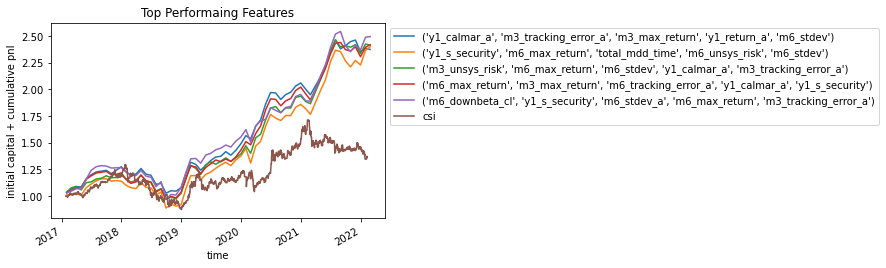

In [40]:
plot_features(pnl_5_feature_random, top_5_comb)

In [399]:
# pnl_top_20 = quantile_all_features(data, top_20_feature, 5, 1)

In [400]:
# for fea in top_20_feature[-5:]:
#     plt.plot(np.cumsum(pnl_top_20[fea]))
# plt.legend(top_20_feature[-5:])
# plt.title('cumulative pnl over 60 months using quantile trading with one feature but with rebalacing every two months')
# plt.xlabel('month since 2017-01-01')
# plt.ylabel('dollar')

### Process Return Data

In [46]:
# Fund ids in the pickle data
fund_ids = list(data.fund_id.unique())
fund_ids = tuple([f"{x:06d}" for x in fund_ids])

In [48]:
return_query = ("""select fund_id, statistic_date,added_nav from fund_nv
where fund_id in {fund_id}
and 
statistic_date > '2017-01-01'""")

In [370]:
s = sql.sqlconnector(credentials.HOST,credentials.USER,credentials.PASSWORD,credentials.PORT,'product_mutual')

In [371]:
s.connect()

Connection Success


In [372]:
df_return = s.fetch(return_query.format(fund_id = fund_ids))

In [373]:
# Calculate forward monthly return
df_return.fund_id = pd.to_numeric(df_return.fund_id)
df_return.statistic_date = pd.to_datetime(df_return.statistic_date)
#df.added_nav = pd.to_numeric(df.added_nav)

df_monthly_return = []

for fund in fund_ids:
    df = df_return[df_return.fund_id == int(fund)].copy()
    df['added_nav'] = df['added_nav'].replace({0:np.nan})
    df.index = df.statistic_date
    idx = pd.date_range(df.index[0], df.index[-1])
    df = df.reindex(idx).fillna(method='ffill')
    
    after = df.reindex(df.index + pd.DateOffset(months=1))
    after.index = df.index
    df['added_return_monthly'] = after['added_nav']/df['added_nav'] - 1
    
    df_monthly_return.append(df)

In [374]:
df_ret = pd.concat(df_monthly_return,axis=0)
df_ret = df_ret.rename({'added_return_monthly': 'ret'}, axis=1)
df_ret.ret = pd.to_numeric(df_ret.ret)
df_ret = df_ret.drop(['statistic_date'], axis=1)
df_ret.reset_index(inplace=True)
df_ret = df_ret.rename({'index': 'statistic_date'}, axis=1)
df_ret['ret'] = df_ret['ret'].replace({np.nan:0})

In [375]:
df_ret.head()

statistic_date  fund_id added_nav       ret
0     2017-01-03      8.0  1.714600 -0.015164
1     2017-01-04      8.0  1.733500 -0.025901
2     2017-01-05      8.0  1.734700 -0.026575
3     2017-01-06      8.0  1.728000 -0.015162
4     2017-01-07      8.0  1.728000 -0.015683

In [385]:
df_ret.to_pickle('ret.pickle')

### Delayed Quantile Trading

In [63]:
pnl_5d_delay = quantile_delayed(data, df_ret, top_20_feature, num_funds=5)

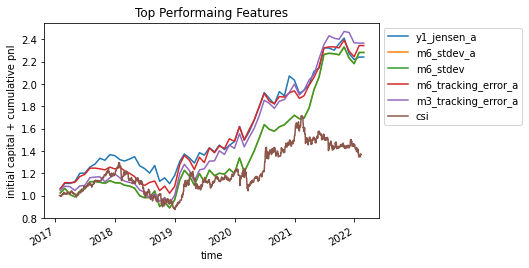

In [64]:
top_5_delay = top_features(pnl_5d_delay, 5)
plot_features(pnl_5d_delay, top_5_delay)

In [65]:
top_5_delay

['y1_jensen_a',
 'm6_stdev_a',
 'm6_stdev',
 'm6_tracking_error_a',
 'm3_tracking_error_a']

In [66]:
pnl_random_delayed = random_feature_quantile_delayed(data, df_ret, top_20_feature, num_comb=100,num_funds=5)

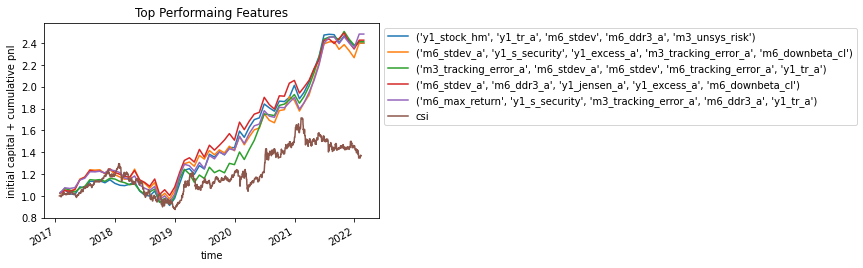

In [67]:
top_5_delay_ran = top_features(pnl_random_delayed, 5)
plot_features(pnl_random_delayed, top_5_delay_ran)

In [68]:
pnl_random_delayed_10 = random_feature_quantile_delayed(data, df_ret, top_20_feature, num_comb=100,num_feature=10,num_funds=5)

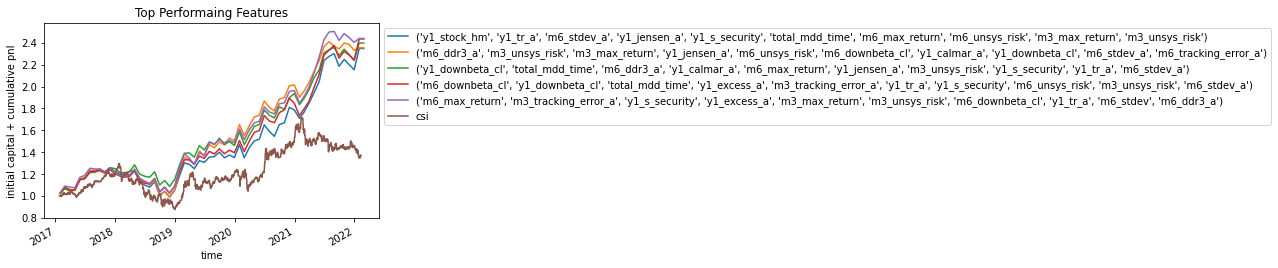

In [69]:
top_10_delay_ran = top_features(pnl_random_delayed_10, 5)
plot_features(pnl_random_delayed_10, top_10_delay_ran)

### Backtesting

In [384]:
def backtest(data, return_data, all_features, num_features = 5, num_funds=50, month=1, look_back=3, delay=5 , positioning = True):
    
    selected_features_all = []
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = []
    selected_funds = []
    for i, date in enumerate(dates[look_back::month]):
        pnl_period = quantile_delayed(data[(data.statistic_date >= dates[i-look_back]) & (data.statistic_date <= date)], return_data[(return_data.statistic_date >= dates[i-look_back]) & (return_data.statistic_date <= date)], all_features, num_funds=5, month=1, delay=5)
        features = top_features(pnl_period, num_features)
        selected_features_all.append(features)
        col = features+['fund_id', 'ret']
        df = data[data.statistic_date == date][col].dropna()
        df['score'] = stats.zscore(df[features]).sum(axis=1)
        ret = 0
        df = df.sort_values(by='score', ascending=False)
        funds = list(df.fund_id[:num_funds])
        selected_funds.append(funds)
        
        if positioning:
            size = np.array([max(1/(i+1) - 1/50,0) for i in range(num_funds)])
            size = 1 / sum(size) * size
        else:
            size = [1 / num_funds for i in range(num_fund)]

        for j,fund in enumerate(funds):
            ret_per_fund = 1
            for i in range(month):
                month_ret = return_data[(return_data.statistic_date == (date + pd.DateOffset(months=i)+pd.Timedelta(str(delay)+'d'))) & (return_data.fund_id == fund)].ret.values
                if month_ret.size > 0:
                    cost = 2 * (data[(data.statistic_date == date) & (data.fund_id==fund)]['fee'] / 12).values[0]
                    ret_per_fund *= ((1 + month_ret[0] * size[j] * (1 - cost)))
                else:
                    break
            ret += ret_per_fund-1
        pnl.append(ret)
        
    return pnl, selected_features_all, selected_funds

### Load Optimal Features

In [219]:
optimal_features = pd.read_pickle('rf_optimal_features_monthly.pickle')
from collections import Counter

In [239]:
opt = [np.array(optimal_features[i]) for i in range(len(optimal_features))]
ordered_feat = Counter(np.concatenate(opt,axis=0)).most_common()
most_common_feat = [x[0] for x in ordered_feat if x[1]>5]

### Optimization

In [241]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
import pickle
warnings.filterwarnings("ignore")
from functools import partial

In [250]:
def objective(trial:Trial, data = None, df_ret = None, most_common_feat = None):

    look_back = trial.suggest_int('look_back', 1,6,step=1)
    delay = trial.suggest_int('delay', 3,5,step=1)
    num_funds = trial.suggest_int('num_funds', 4,20,step=2)
    num_features = trial.suggest_int('num_features', 1,50,step=5)
    
    pl, f = backtest(data, df_ret, most_common_feat, num_features = num_features, num_funds= num_funds,month=1,look_back=look_back, delay=delay)
    profit = (np.cumsum(pl)+1)[-1]
    return profit

In [251]:
study = optuna.create_study(direction="maximize")

In [254]:
%%time
study.optimize(partial(objective,data = data, df_ret = df_ret, most_common_feat = most_common_feat), n_trials=10,n_jobs=-1)

CPU times: user 4min 47s, sys: 35.2 s, total: 5min 22s
Wall time: 3min 38s


In [273]:
study.best_params

{'look_back': 1, 'delay': 3, 'num_funds': 11, 'num_features': 6}

In [407]:
data = load_data('data_new.pickle')

In [409]:
df_ret = pd.read_pickle('ret.pickle')
optimal_features = pd.read_pickle('rf_optimal_features_monthly.pickle')

In [410]:
pl, f, funds = feature_selection_quantile(data, df_ret, most_common_feat,month=month, **study.best_params )

<AxesSubplot:title={'center':'Strategy Return vs CSI 300'}>

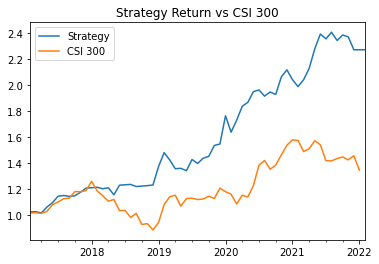

In [430]:
perf = pd.DataFrame(np.cumsum(pl)+1,index = dates[study.best_params['look_back']:],columns = ['Strategy'])
perf['CSI 300'] = df_csi.Price/df_csi.Price[0]
perf.plot(title = 'Strategy Return vs CSI 300')

In [424]:
# plt.plot(dates[study.best_params['look_back']:],np.cumsum(pl)+1)
# (df_csi.Price/df_csi.Price[0]).plot(label='CSI')

# plt.legend(['calculating top {num_features} features every month'.format(num_features = study.best_params['num_features']),'csi'],bbox_to_anchor=(1, 1))
# plt.title('PnL')
# plt.xlabel('time')
# plt.ylabel('initial capital + cumulative pnl')
# plt.show()

In [431]:
metrics = ['mean','sharpe','max_drawdown','volatility','skew','excess_kurtosis','var','cvar']

In [432]:
performance_matrix(perf.pct_change(),metrics = metrics).T

mean    sharpe  max_drawdown  volatility      skew  \
Strategy  0.168373  1.252804     -0.093338    0.134397  0.736626   
CSI 300   0.069140  0.419093     -0.295903    0.164975  0.318065   

          excess_kurtosis       var      cvar  
Strategy        -1.726984 -0.041884 -0.054573  
CSI 300         -2.350511 -0.076249 -0.079519

##### Get most common features

In [436]:
feature_dic = {}
for ls in f:
    for element in ls:
        feature_dic[element] = feature_dic.get(element, 0) + 1
sort_feature_dic = dict(sorted(feature_dic.items(), key=lambda item: item[1]))

In [438]:
# Top 10 features that appeared the most (and how many times they appeared)
list(sort_feature_dic.items())[-10:]

[('m3_VaR', 14),
 ('m6_stdev', 15),
 ('m6_assess_ratio', 16),
 ('m3_unsys_risk', 16),
 ('m3_return', 16),
 ('quarter_return', 16),
 ('year_return', 16),
 ('m6_min_return', 17),
 ('m3_sor_a', 18),
 ('m3_max_return', 19)]